In [1]:
import torch
from torchtext import data
import torch.nn as nn
import torch.nn.functional as F
import time

# 计算预测的准确率

def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc


# 不用优化器了
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    total_len = 0

    # 转成测试模式，冻结dropout层或其他层
    model.eval()

    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.text.permute(1, 0))
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item() * len(batch.label)
            epoch_acc += acc.item() * len(batch.label)
            total_len += len(batch.label)

        # 调回训练模式
        model.train()

    return epoch_loss / total_len, epoch_acc / total_len

import time

# 查看每个epoch的时间
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    total_len = 0

    model.train()

    for batch in iterator:
        optimizer.zero_grad()
        # batch.text 就是上面forward函数的参数text
        # 压缩维度，不然跟 batch.label 维度对不上
        predictions = model(batch.text.permute(1, 0))
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)

        loss.backward()  # 反向传播
        optimizer.step()  # 梯度下降
        # loss.item() 以及本身除以了 len(batch.label)
        # 所以得再乘一次，得到一个batch的损失，累加得到所有样本损失
        epoch_loss += loss.item() * len(batch.label)

        # (acc.item(): 一个batch的正确率) * batch数 = 正确数
        # train_iterator 所有batch的正确数累加
        epoch_acc += acc.item() * len(batch.label)
        total_len += len(batch.label)
        # print('train loss = ', epoch_loss / total_len, '| train acc = ', epoch_acc / total_len)

    # epoch_loss / total_len ：train_iterator所有batch的损失
    # epoch_acc / total_len ：train_iterator所有batch的正确率
    return epoch_loss / total_len, epoch_acc / total_len


#================================================分隔符=================================================================


import torch
from torchtext import data
import torch.nn as nn
import torch.nn.functional as F
import random
SEED = 1234

torch.manual_seed(SEED)  # 为CPU设置随机种子
torch.cuda.manual_seed(SEED)  #为GPU设置随机种子
# 在程序刚开始加这条语句可以提升一点训练速度，没什么额外开销
torch.backends.cudnn.deterministic = True

# 首先，我们要创建两个Field 对象：这两个对象包含了我们打算如何预处理文本数据的信息。
# spaCy:英语分词器,类似于NLTK库，如果没有传递tokenize参数，则默认只是在空格上拆分字符串。
# torchtext.data.Field : 用来定义字段的处理方法（文本字段，标签字段）
TEXT = data.Field(tokenize='spacy',fix_length=380)
#LabelField是Field类的一个特殊子集，专门用于处理标签。
LABEL = data.LabelField(dtype=torch.float)

# 加载IMDB电影评论数据集
from torchtext import datasets
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

# 默认split_ratio=0.7
train_data, valid_data = train_data.split(split_ratio=0.8, random_state=random.seed(SEED))
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

# 从预训练的词向量（vectors）中，将当前(corpus语料库)词汇表的词向量抽取出来，构成当前 corpus 的 Vocab（词汇表）
# 预训练的 vectors 来自glove模型，每个单词有100维。glove模型训练的词向量参数来自很大的语料库
# 而我们的电影评论的语料库小一点，所以词向量需要更新，glove的词向量适合用做初始化参数。
TEXT.build_vocab(train_data, max_size=5000, vectors="glove.6B.100d", unk_init=torch.Tensor.normal_)
LABEL.build_vocab(train_data)

print(f'Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}')
print(f'Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}')

BATCH_SIZE = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 相当于把样本划分batch，知识多做了一步，把相等长度的单词尽可能的划分到一个batch，不够长的就用padding。
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device
)



Number of training examples: 20000
Number of validation examples: 5000
Number of testing examples: 25000
Unique tokens in TEXT vocabulary: 5002
Unique tokens in LABEL vocabulary: 2


In [2]:

import torch.nn as nn
# None是batch_size
class CNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, n_filters, filter_size,
               output_dim, dropout, pad_idx):
        super(CNN, self).__init__()
        self.embedded = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_idx)
        self.conv1 = nn.Sequential(  # input shape ( None, 64, 380)
            nn.Conv1d(
                in_channels=embedding_dim,      # input height
                out_channels=n_filters,    # n_filters
                kernel_size=filter_size,      # filter size
                stride=1,           # filter movement/step
                padding=1,      # 如果想要 con2d 出来的图片长宽没有变化,当 stride=1 padding=(kernel_size-1)/2
            ),      # output shape  batch_size x n_filters x embedding_size: (100, 100, 380)
            nn.ReLU(),    # activation
            nn.MaxPool1d(kernel_size=2),    # 在 2x2 空间里向下采样, output shape (batch_size, 128, 190)
        )
        self.out = nn.Sequential(
            nn.Linear(256*190, 256),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(256,output_dim),
        )

    def forward(self, text):
        embedded = self.embedded(text)
        embedded = embedded.permute(0,2,1)  # batch_size x text_len x embedding_size -> batch_size x embedding_size x text_len(100, 64, 380)
        conv1ed = self.conv1(embedded)
#         print('x after conv1 size',x.size())
        conv1ed = conv1ed.view(conv1ed.size(0), -1)   # 展平多维的卷积图成 (batch_size, 128, 190)
        output = self.out(conv1ed)
        return output.squeeze()

In [3]:


# 初始化参数
pretrained_embeddings = TEXT.vocab.vectors
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 64
N_FILTERS = 256
FILTER_SIZES = 3
OUTPUT_DIM = 1
DROPOUT = 0.2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
# model.embedded.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
model.embedded.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedded.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
model = model.to(device)
print(model)

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

N_EPOCHS = 20

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'CNN-model.pt')

    print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}%')


#        测试
    model.load_state_dict(torch.load('CNN-model.pt'))
    test_loss, test_acc = evaluate(model, test_iterator, criterion)
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')

CNN(
  (embedded): Embedding(5002, 64, padding_idx=1)
  (conv1): Sequential(
    (0): Conv1d(64, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=48640, out_features=256, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)
Epoch: 01 | Epoch Time: 0m 16s
	Train Loss: 0.806 | Train Acc: 49.87%
	 Val. Loss: 0.693 |  Val. Acc: 50.80%
Test Loss: 0.693 | Test Acc: 50.00%
Epoch: 02 | Epoch Time: 0m 15s
	Train Loss: 0.693 | Train Acc: 49.79%
	 Val. Loss: 0.693 |  Val. Acc: 50.78%
Test Loss: 0.693 | Test Acc: 50.00%
Epoch: 03 | Epoch Time: 0m 15s
	Train Loss: 0.694 | Train Acc: 49.81%
	 Val. Loss: 0.693 |  Val. Acc: 50.78%
Test Loss: 0.693 | Test Acc: 50.00%
Epoch: 04 | Epoch Time: 0m 16s
	Train Loss: 0.693 | Train Acc: 49.55%
	 Val. Loss: 0.693 |  Val. Acc: 50.78%

In [4]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
import numpy as np

model.load_state_dict(torch.load('CNN-model.pt'))
model.eval()

test_pred = np.array([])
test_labels = np.array([])
final_out = np.array([])
with torch.no_grad():
    for batch in test_iterator:
        predictions_torch = torch.sigmoid(model(batch.text.permute(1, 0)))
        predictions = predictions_torch.cpu().numpy()
        test_pred = np.append(test_pred,predictions)
        test_labels = np.append(test_labels,batch.label.cpu().numpy())
        final_out = np.append(final_out,torch.round(predictions_torch).cpu().numpy())
        
print(np.size(test_pred))
print(np.size(test_labels))
print(np.size(final_out))

25000
25000
25000


In [5]:
from sklearn.metrics import classification_report
print(classification_report(test_labels,final_out))

precision    recall  f1-score   support

         0.0       0.79      0.89      0.83     12500
         1.0       0.87      0.76      0.81     12500

    accuracy                           0.82     25000
   macro avg       0.83      0.82      0.82     25000
weighted avg       0.83      0.82      0.82     25000



In [6]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels,test_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
len(true_positive_rate)

3244

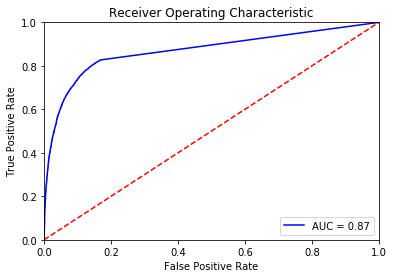

In [7]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()